This notebook gives some fundamentals on Bagging and Boosting methods for the star/galaxy/quasar classification.

Written with ❤️ by Viviana Acquaviva for the LSST Data Science Fellowship lecture series.

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

We follow the same steps as before to derive the final data set. Note - because we are dealing with more complex models, I am reducing the sample size to ~10,000 (feel free to change frac to 0.05 if needed).

In [ ]:
data = pd.read_csv('star_classification.csv', sep = ',')

df = data.sample(frac = 0.1, random_state = 11)

df.reset_index(drop = True, inplace=True)

In [ ]:
seldf = df[['u','g','r','i','z']]

In [ ]:
for col in seldf.columns:
    seldf = seldf[seldf[col] >= 0]

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder() #turns categorical into 1 ... N

In [ ]:
y = le.fit_transform(df['class'].values)

In [ ]:
le.classes_

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

In [ ]:
target = y[seldf.index]

### Random Forest

In [ ]:
model = RandomForestClassifier()

In [ ]:
cv = KFold(n_splits=5, random_state=10, shuffle= True)

We can establish a benchmark, as usual:

In [ ]:
scores = cross_validate(model, seldf, target, cv = cv, return_train_score = True)

In [ ]:
print("Time: %.3fs, Mean train score: %.3f, Mean test score: %.3f, std: %.3f"%(scores['score_time'].mean(), scores['train_score'].mean(), scores['test_score'].mean(), scores['test_score'].std()))

As usual, we can get a landscape of model parameters like this:

In [ ]:
model.get_params()

It may be useful to distinguish between the parameters of the decision tree, the randomization process, and the averaging process.

#### Tree Parameters

Some useful parameters associated to a tree are:

- the minimum number of instances in a leaf node; 
- the minimum number of instances required in a split node;
- the maximum depth of tree;
- the minimum information gain required to decide whether a split is "worth it".

#### Randomization Parameters

Here we find:

-    The number of k < n features that are used in building trees (max_features);

-    The re-sampling (boostrap) of the data set (T or F).

#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.



### Optimizing hyperparameters

Finally, the cell below shows how to run a Grid Search for the parameters for some example sets; if a Grid Search is too expensive, we can also run a Randomized Search, which doesn't guarantee that we'll find the best model, but usually gets us close enough.

In [ ]:
#Takes ~ 25 secs min for me

parameters = {'min_impurity_decrease':[0.5, 0.2, 0.0], \
              'max_features':[None,4,2], 'n_estimators':[10, 50, 100], 'max_depth': [5,10]}

model = GridSearchCV(RandomForestClassifier(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)
model.fit(seldf,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

We can save the results in a data frame, and look at the best models to build some intution.

In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [ ]:
scoresCV

Q: what parameters seem to be consistently important for the top models? And which ones are not important?

For comparison, this is how to set up a Randomized Search:

In [ ]:
parameters = {'min_impurity_decrease':[0.5, 0.2, 0.0], \
              'max_features':[None,4,2], 'n_estimators':[10, 50, 100], 'max_depth': [5,10]}

model = RandomizedSearchCV(RandomForestClassifier(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True, n_iter = 30)
model.fit(seldf,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

#### Q: What is the most convenient strategy here?

### XGBoost

Medium article explaining XGBoost: [here](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7); some nice tutorials from XGBoost's site: [here](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
model.get_params()

This is one possible grid (note - this takes a few minutes on my machine)!

In [ ]:
parameters = {'max_depth': [5,10], 'n_estimators':[10, 50,100], 
              'learning_rate': [0.05, 0.1, 0.2], 'subsample':[0.5,1]}

model = GridSearchCV(xgb.XGBRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)

model.fit(seldf,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

### Task: 

### Try to improve on our current scores, by further optimizing a RF or XGB, and/or by engineering new features that could be helpful.

### Feature importance

Tree-based methods have a built-in feature importance method. It is important that the estimator has been "fit" before you can access the feature importances. If you are using this just to build an understanding of which features most participate to a prediction (and not to assess the performance of a model with a given set of features), you can use the full learning set.

Note:

The ranking (more in general, the information gain associated to each feature) is algorithm-dependent and often affected by correlations among variables. I would encourage you to think about it as an indication, and/or to derive it for a few different algorithms to increase robustness.


In [145]:
model

DecisionTreeClassifier()

In [147]:
model.fit(seldf, target)

DecisionTreeClassifier()

In [148]:
model.feature_importances_

array([0.16167098, 0.25731071, 0.16387238, 0.08455175, 0.33259417])

Feature ranking:
1. feature: z, 4 (0.332594)
2. feature: g, 1 (0.257311)
3. feature: r, 2 (0.163872)
4. feature: u, 0 (0.161671)
5. feature: i, 3 (0.084552)


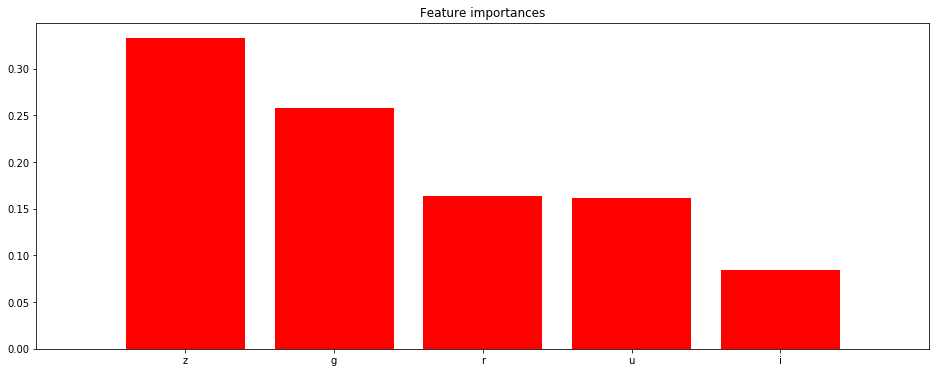

In [149]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(seldf.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, seldf.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(seldf.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(seldf.shape[1]), seldf.columns[indices])
plt.xlim([-1, seldf.shape[1]])
plt.show()